In [12]:
import pandas as pd
import numpy as np

import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc

from imblearn.over_sampling import RandomOverSampler

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [13]:
nltk.download('stopwords');
nltk.download('punkt');
nltk.download('wordnet');

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alvaro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Alvaro\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Alvaro\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
file_path = "../Data/spam_dataset.csv"

df = pd.read_csv(file_path)
df.head()

,Unnamed: 0,Body,Label
0,0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
1,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
2,2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3,3,##############################################...,1
4,4,I thought you might like these:\n1) Slim Down ...,1


In [15]:
df = df[['Body', 'Label']]
df.columns = ['message_content', 'is_spam']

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6046 entries, 0 to 6045
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   message_content  6045 non-null   object
 1   is_spam          6046 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 94.6+ KB


In [17]:
df.dropna(inplace = True)
df.is_spam.value_counts()

is_spam
0    4150
1    1895
Name: count, dtype: int64

In [18]:
stop_words = set(stopwords.words('english'))

In [19]:
lemmatizer = WordNetLemmatizer()

In [20]:
def preprocess_text(text):
    
    text = text.lower()
    
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\d', ' ', text)
    
    tokens = word_tokenize(text)
    
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [21]:
df['cleaned_message'] = df['message_content'].apply(preprocess_text)

In [22]:
df.head()

,message_content,is_spam,cleaned_message
0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1,save life insurance spend life quote saving en...
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,fight risk cancer http www adclick w p cfm pk ...
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,fight risk cancer http www adclick w p cfm pk ...
3,##############################################...,1,adult club offer free membership instant acces...
4,I thought you might like these:\n1) Slim Down ...,1,thought might like slim guaranteed lose lb day...


In [23]:
vectorizer = TfidfVectorizer(max_features = 5000)

X = vectorizer.fit_transform(df['cleaned_message']).toarray()
y = df['is_spam']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = 42, 
                                                    stratify = y)

In [25]:
ros = RandomOverSampler(random_state=42)

X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

print(y_train.value_counts())
print(y_train_resampled.value_counts())

is_spam
0    3320
1    1516
Name: count, dtype: int64
is_spam
1    3320
0    3320
Name: count, dtype: int64


# Selección de modelos

In [26]:
models_pipeline = Pipeline([('clf', 'model')])

In [27]:
parameters = [
    {
        'clf': [KNeighborsClassifier()],
        'clf__n_neighbors': np.arange(3, 26, 2),
        'clf__weights': ['uniform', 'distance'],
        'clf__metric': ['euclidean', 'manhattan']
    },
    {
        'clf': [LogisticRegression()],
        'clf__penalty': ['l2'],
        'clf__C': [0.1, 1, 10],
        'clf__solver': ['lbfgs', 'liblinear']
    },
    {
        'clf': [RandomForestClassifier()],
        'clf__n_estimators': [10, 50, 100],
        'clf__max_depth': [None, 10, 20, 30],
        'clf__min_samples_split': [2, 5, 10]
    },
    {
        'clf': [SVC()],
        'clf__C': [0.1, 1, 10],
        'clf__kernel': ['linear', 'rbf', 'poly']
    },
    {
        'clf': [DecisionTreeClassifier()],
        'clf__max_depth': [None, 10, 20, 30],
        'clf__min_samples_split': [2, 5, 10],
        'clf__criterion': ['gini', 'entropy']
    }
]

In [28]:
grid_search = GridSearchCV(models_pipeline, 
                           param_grid = parameters, 
                           cv = 5, 
                           n_jobs = -1, 
                           scoring = 'accuracy')

grid_search

GridSearchCV(cv=5, estimator=Pipeline(steps=[('clf', 'model')]), n_jobs=-1,
             param_grid=[{'clf': [KNeighborsClassifier()],
                          'clf__metric': ['euclidean', 'manhattan'],
                          'clf__n_neighbors': array([ 3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25]),
                          'clf__weights': ['uniform', 'distance']},
                         {'clf': [LogisticRegression()], 'clf__C': [0.1, 1, 10],
                          'clf__penalty': ['l2'],
                          'clf__solver': ['lbfgs',...
                         {'clf': [RandomForestClassifier()],
                          'clf__max_depth': [None, 10, 20, 30],
                          'clf__min_samples_split': [2, 5, 10],
                          'clf__n_estimators': [10, 50, 100]},
                         {'clf': [SVC()], 'clf__C': [0.1, 1, 10],
                          'clf__kernel': ['linear', 'rbf', 'poly']},
                         {'clf': [DecisionTreeClassifier()],
                          'clf__criterion': ['gini', 'entropy'],
                          'clf__max_depth': [None, 10, 20, 30],
                          'clf__min_samples_split': [2, 5, 10]}],
             scoring='accuracy')

In [ ]:
grid_search.fit(X_train, y_train)

In [36]:
grid_search.best_params_

{'clf': SVC(), 'clf__C': 10, 'clf__kernel': 'linear'}

## Comments: 
---
- Best models: Support Vector Classifier (SVC):
- `{'clf': SVC(), 'clf__C': 10, 'clf__kernel': 'linear'}`

In [33]:
grid_search_df = pd.DataFrame(grid_search.cv_results_['params'])

In [37]:
model = grid_search.best_params_['clf']
model

SVC()

In [38]:
best_params = {key.replace('clf__', ''): value for key, value in grid_search.best_params_.items() if key != 'clf'}
best_params

{'C': 10, 'kernel': 'linear'}

In [50]:
best_params['probability'] = True # Add the probability=True parameter required for the ROC Curve
model = model.set_params(**best_params)
model.fit(X_train_resampled, y_train_resampled)

SVC(C=10, kernel='linear', probability=True)

In [51]:
y_pred = model.predict(X_test)

In [52]:
print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")

Accuracy: 95.78%


# Model Performance

In [53]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       830
           1       0.89      0.98      0.94       379

    accuracy                           0.96      1209
   macro avg       0.94      0.96      0.95      1209
weighted avg       0.96      0.96      0.96      1209



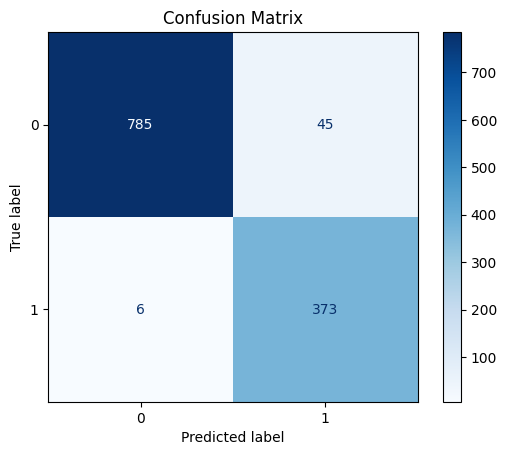

In [54]:
# Crear la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Mostrar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap = plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

### Metrics Takeways
---
- The confusion matrix shows that the model has a good balance between precision and recall, with a strong ability to correctly identify both classes. This is indicative of a well-performing model in this classification task.

## Receiving Operating Characteristic (ROC Curve)

In [55]:
y_prob = model.predict_proba(X_test)[:, 1]

In [56]:
# Calcular la curva ROC y el AUC (Area Under the Curve)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

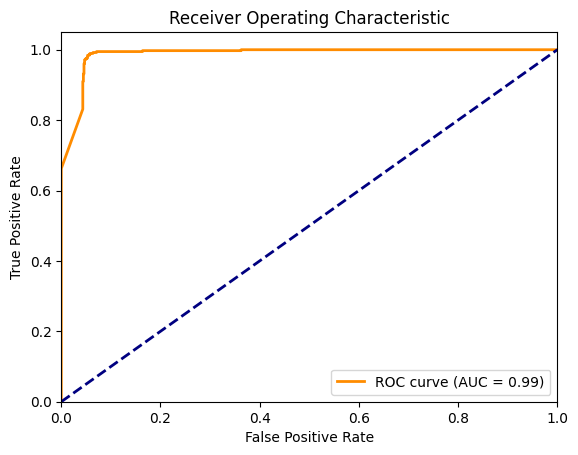

In [58]:
# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### ROC Curve takeaways
---
- **High AUC (0.99): **The model is performing extremely well, with a strong ability to distinguish between positive and negative cases.
- **Close to Top-Left Corner:** The ROC curve’s proximity to the top-left corner further reinforces the model’s high performance.
- **Low FPR and High TPR:** For most thresholds, the model maintains a low rate of false positives while achieving a high rate of true positives.